## Importing Packages and Loading Dataset

In [1]:
# Importing all the necessary packages and libraries

import numpy as np

import pandas as pd

import cvxpy as cp

from matplotlib import pyplot as plt

import seaborn as sns

In [2]:
# Reading the data from the excel file

data = pd.read_excel('../spx_returns_weekly.xlsx', sheet_name=2)

# Reading the benchmark data from the excel file

benchmark_data = pd.read_excel('../spx_returns_weekly.xlsx', sheet_name=3)

# Selecting only the specified columns

data = data[['date', 'AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'BRK/B', 'LLY']]

# Selecting only the specified columns

benchmark_data = benchmark_data[['date', 'SPY']]

# Combining the dataframes

data = pd.merge(data, benchmark_data, on='date', how='left')

## Return, Volatility and Sharpe Ratio

In [3]:
# Calculating the mean returns

mean_returns_weekly = data.select_dtypes(include=[np.number]).mean()

# Calculate the volatility

volatility_weekly = data.select_dtypes(include=[np.number]).std()

# Sharpe Ratio

sharpe_ratio = (mean_returns_weekly/volatility_weekly)*np.sqrt(52)

# Calculate the covariance matrix

cov_matrix_weekly = data.select_dtypes(include=[np.number]).cov()

# Convert the mean returns and covariance matrix to numpy arrays

mean_returns_weekly_v = mean_returns_weekly.values

cov_matrix_weekly_v = cov_matrix_weekly.values

# Create a DataFrame summarizing annual metrics for each stock
result = pd.DataFrame({
    'Annual Return': mean_returns_weekly * 52,
    'Annual Volatility': volatility_weekly * np.sqrt(52),
    'Sharpe Ratio': sharpe_ratio,
    'Shapre Ratio Rank': sharpe_ratio.rank(ascending=False)
})

result

,Annual Return,Annual Volatility,Sharpe Ratio,Shapre Ratio Rank
AAPL,0.238714,0.276629,0.862938,6.0
NVDA,0.645580,0.463283,1.393490,1.0
MSFT,0.261402,0.239980,1.089266,2.0
GOOGL,0.216800,0.279851,0.774698,8.0
AMZN,0.293447,0.306000,0.958976,5.0
META,0.261924,0.351336,0.745509,10.0
TSLA,0.469754,0.586431,0.801039,7.0
AVGO,0.394854,0.375132,1.052574,3.0
BRK/B,0.135025,0.190654,0.708223,11.0
LLY,0.281542,0.282980,0.994919,4.0


## Correlation Matrix for given Stocks and SPY

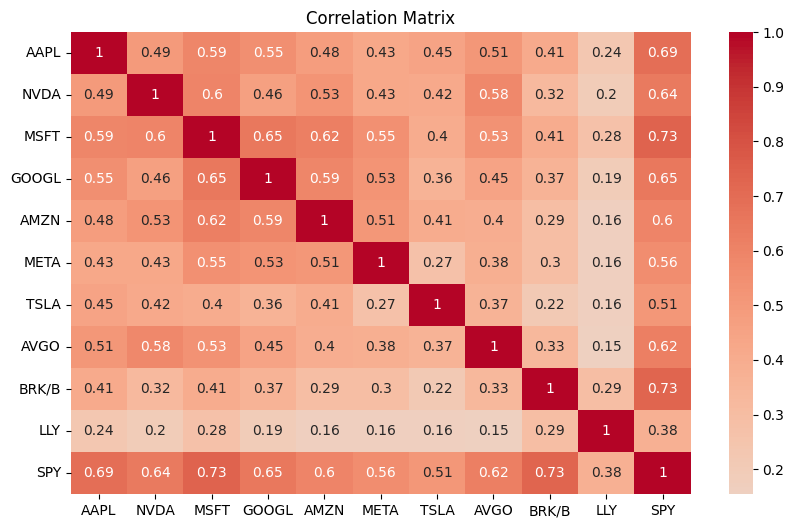

In [4]:
# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Constrained Portfolio Optimization

In [5]:
# Define the number of assets
n_assets = len(mean_returns_weekly_v)

# Define the weights
weights = cp.Variable(n_assets)

# Define the objective function (minimize portfolio variance)
objective = cp.Minimize(cp.quad_form(weights, cov_matrix_weekly_v))

# Target mean return and weekly equivalent
target_annual_return = 0.20
weekly_target_return = target_annual_return/52

# Define constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= -0.20,
    weights <= 0.35,
    weights @ mean_returns_weekly_v == weekly_target_return
]

# Create the optimization problem
problem = cp.Problem(objective, constraints)

In [6]:
# Solve the problem
result = problem.solve()

# Print the optimal weights with stock tickers
optimal_weights = pd.Series(weights.value, index=mean_returns_weekly.index)
optimal_weights

AAPL     0.029583
NVDA    -0.013603
MSFT     0.145178
GOOGL    0.008862
AMZN     0.093423
META     0.002375
TSLA    -0.016155
AVGO     0.036173
BRK/B    0.350000
LLY      0.213318
SPY      0.150845
dtype: float64

In [7]:
optimal_weights.sum(), optimal_weights.min(), optimal_weights.max(), (optimal_weights@mean_returns_weekly_v)*52

(1.0, -0.016154986939810465, 0.35, 0.20000000000000004)

#### We can see that it satisfies all the constraints

In [8]:
optimal_portfolio_annual_return = (optimal_weights@mean_returns_weekly_v)*52

optimal_portfolio_annual_volatility = np.sqrt(optimal_weights @ cov_matrix_weekly_v @ optimal_weights)*np.sqrt(52)

optimal_portfolio_sharpe = optimal_portfolio_annual_return/optimal_portfolio_annual_volatility

results = pd.DataFrame({
    'Portfolio': ['Optimal'],
    'Annual Return': [optimal_portfolio_annual_return],
    'Annual Volatility': [optimal_portfolio_annual_volatility],
    'Sharpe Ratio': [optimal_portfolio_sharpe]
})

results

,Portfolio,Annual Return,Annual Volatility,Sharpe Ratio
0,Optimal,0.2,0.164888,1.212945


## Compare optimal portfolio weights, Sharpe ratios, and returns

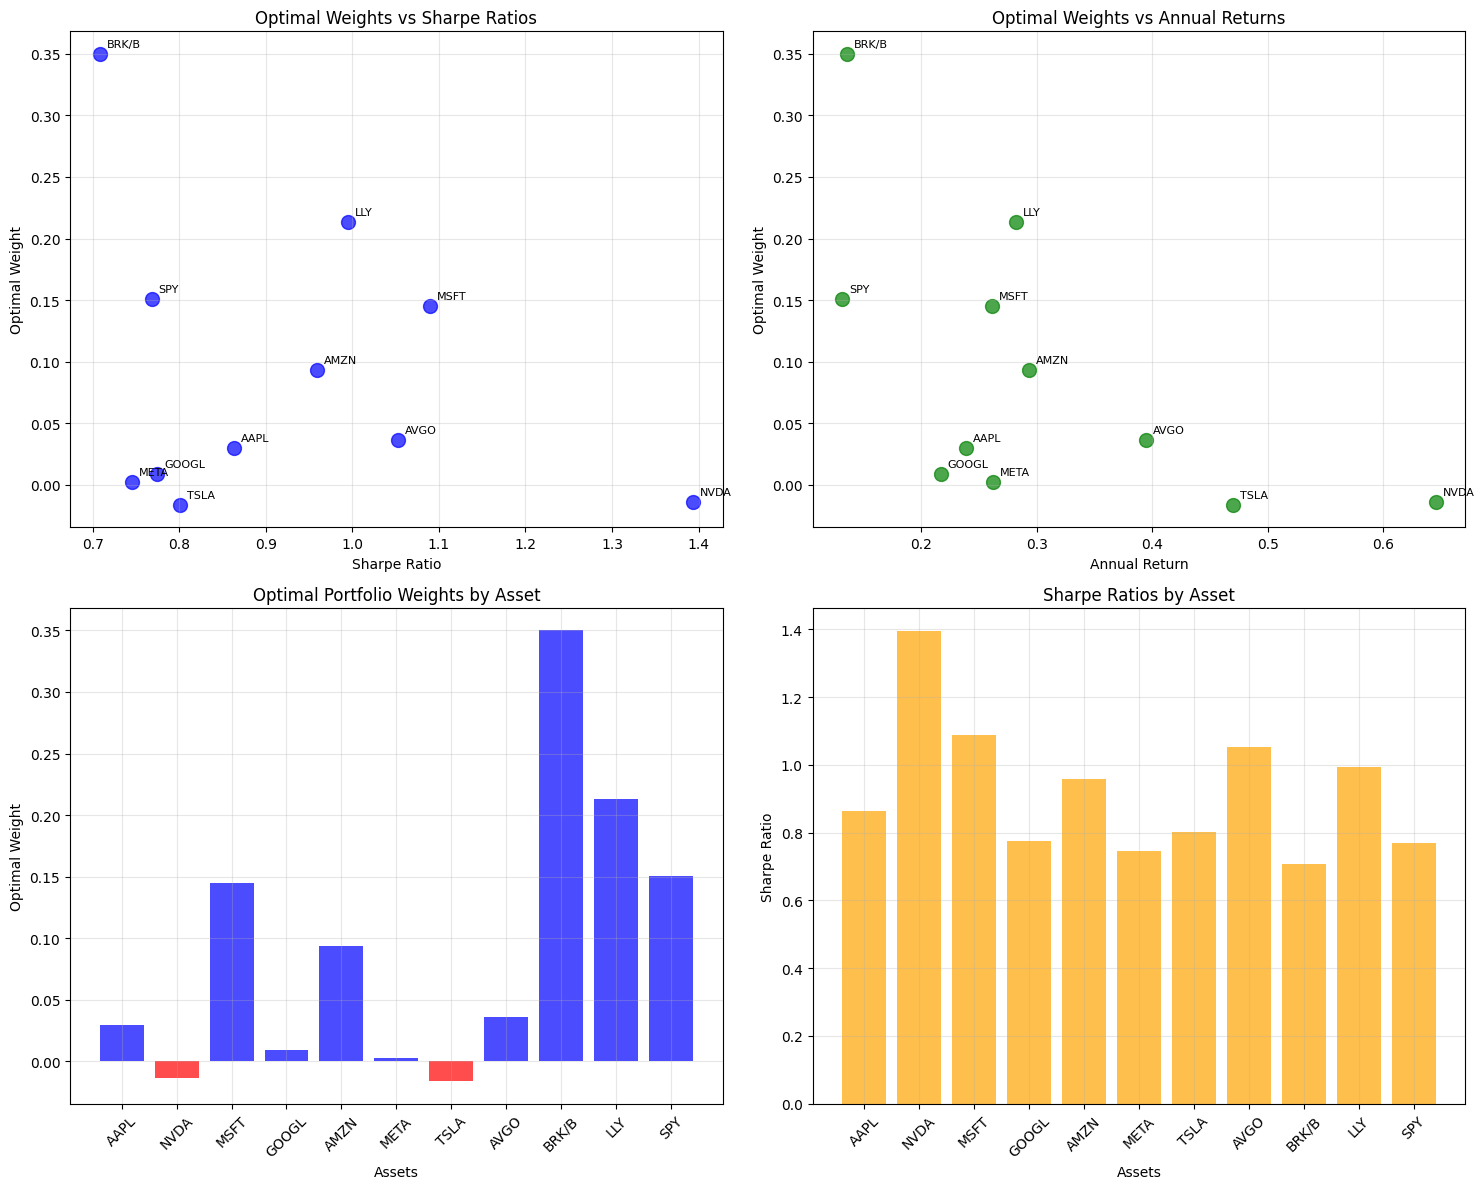

In [9]:
# Comparison DataFrame for each asset
comparison_df = pd.DataFrame({
    'Asset': mean_returns_weekly.index,
    'Optimal Weight': optimal_weights.values,
    'Annual Return': mean_returns_weekly.values * 52,
    'Annual Volatility': np.sqrt(np.diag(cov_matrix_weekly.values)) * np.sqrt(52),
    'Sharpe Ratio': (mean_returns_weekly.values * 52) / (np.sqrt(np.diag(cov_matrix_weekly.values)) * np.sqrt(52))
})

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# Scatter: optimal weights vs Sharpe ratios
ax1.scatter(comparison_df['Sharpe Ratio'], comparison_df['Optimal Weight'], s=100, alpha=0.7, color='blue')
ax1.set_xlabel('Sharpe Ratio')
ax1.set_ylabel('Optimal Weight')
ax1.set_title('Optimal Weights vs Sharpe Ratios')
ax1.grid(True, alpha=0.3)
# Annotate each point with its asset name
for i, row in comparison_df.iterrows():
    ax1.annotate(row['Asset'], (row['Sharpe Ratio'], row['Optimal Weight']), xytext=(5, 5),
                 textcoords='offset points', fontsize=8)

# Scatter: optimal weights vs annual returns
ax2.scatter(comparison_df['Annual Return'], comparison_df['Optimal Weight'], s=100, alpha=0.7, color='green')
ax2.set_xlabel('Annual Return')
ax2.set_ylabel('Optimal Weight')
ax2.set_title('Optimal Weights vs Annual Returns')
ax2.grid(True, alpha=0.3)
# Annotate points with asset name
for i, row in comparison_df.iterrows():
    ax2.annotate(row['Asset'], (row['Annual Return'], row['Optimal Weight']), xytext=(5, 5),
                 textcoords='offset points', fontsize=8)

# Bar plot: optimal weights for each asset
color_map = ['red' if w < 0 else 'blue' for w in comparison_df['Optimal Weight']]
ax3.bar(comparison_df['Asset'], comparison_df['Optimal Weight'], color=color_map, alpha=0.7)
ax3.set_xlabel('Assets')
ax3.set_ylabel('Optimal Weight')
ax3.set_title('Optimal Portfolio Weights by Asset')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Bar plot: Sharpe ratios for each asset
ax4.bar(comparison_df['Asset'], comparison_df['Sharpe Ratio'], color='orange', alpha=0.7)
ax4.set_xlabel('Assets')
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Sharpe Ratios by Asset')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### No, assets with extreme optimal portfolio weights do not necessarily have extreme Sharpe ratios or expected returns. For example, NVDA has a high Sharpe ratio but receives a relatively low weight, while BRK/B has a low Sharpe ratio but receives a high weight in the optimal portfolio. This occurs because optimal weights are not determined solely by individual Sharpe ratios or means, but also by the covariance structure among the assets. Assets that have lower correlations with others (and therefore contribute more to diversification) can receive greater weights, even if their standalone Sharpe ratios are not the highest.

## Unbounded portfolio

In [10]:
# Define the number of assets
n_assets = len(mean_returns_weekly_v)

# Define the weights
weights = cp.Variable(n_assets)

# Define the objective function (minimize portfolio variance)
objective = cp.Minimize(cp.quad_form(weights, cov_matrix_weekly_v))

# Target mean return and weekly equivalent
target_annual_return = 0.20
weekly_target_return = target_annual_return/52

# Define constraints
constraints = [
    weights @ mean_returns_weekly_v == weekly_target_return
]

# Create the optimization problem
problem = cp.Problem(objective, constraints)

# Solve the problem
result = problem.solve()

# Print the optimal weights with stock tickers
optimal_weights_tan = pd.Series(weights.value, index=mean_returns_weekly.index)
optimal_weights_tan

AAPL     0.062872
NVDA     0.135598
MSFT     0.130328
GOOGL    0.029661
AMZN     0.065481
META     0.042605
TSLA     0.047634
AVGO     0.092441
BRK/B    0.396317
LLY      0.170881
SPY     -1.020234
dtype: float64

## Comparision of bounded and unbounded portfolio

In [11]:
# Put into dataframe optimal_weights_tan and optimal_weights
comparison_df = pd.DataFrame({
    'Asset': mean_returns_weekly.index,
    'Optimal Weight Bounded': optimal_weights.values,
    'Optimal Weight Unbounded': optimal_weights_tan.values,
})

comparison_df

,Asset,Optimal Weight Bounded,Optimal Weight Unbounded
0,AAPL,0.029583,0.062872
1,NVDA,-0.013603,0.135598
2,MSFT,0.145178,0.130328
3,GOOGL,0.008862,0.029661
4,AMZN,0.093423,0.065481
5,META,0.002375,0.042605
6,TSLA,-0.016155,0.047634
7,AVGO,0.036173,0.092441
8,BRK/B,0.350000,0.396317
9,LLY,0.213318,0.170881


In [12]:
mean_bounded = (optimal_weights@mean_returns_weekly_v)*52
mean_unbounded = (optimal_weights_tan@mean_returns_weekly_v)*52

vol_bounded = np.sqrt(optimal_weights @ cov_matrix_weekly_v @ optimal_weights)*np.sqrt(52)
vol_unbounded = np.sqrt(optimal_weights_tan @ cov_matrix_weekly_v @ optimal_weights_tan)*np.sqrt(52)

sharpe_bounded = mean_bounded/vol_bounded
sharpe_unbounded = mean_unbounded/vol_unbounded

pd.DataFrame({
    'Portfolio': ['Bounded', 'Unbounded'],
    'Annual Return': [mean_bounded, mean_unbounded],
    'Annual Volatility': [vol_bounded, vol_unbounded],
    'Sharpe Ratio': [sharpe_bounded, sharpe_unbounded]
})

,Portfolio,Annual Return,Annual Volatility,Sharpe Ratio
0,Bounded,0.2,0.164888,1.212945
1,Unbounded,0.2,0.096687,2.068541
